In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"natchapolpatamawisut","key":"bdc0027621c4c2bd403ee36ae0004376"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [8]:
!kaggle datasets download -d sanikamal/horses-or-humans-dataset

401 - Unauthorized


In [4]:
!unzip -q /content/horses-or-humans-dataset.zip
import shutil
shutil.rmtree('/content/horse-or-human/horse-or-human')

In [8]:
import os

path = '/content/horse-or-human'


data = {}

for root, dirs, files in os.walk(path):
  for dir in dirs:
    subpath = os.path.join(root, dir)
    flist = []
    for _,_,file in os.walk(subpath):
      flist += file
    data[subpath] = flist 

for dir in data:
  print(dir,' '*(42-len(dir))+' : ',len(data[dir]),' files')

/content/horse-or-human/train               :  1027  files
/content/horse-or-human/validation          :  256  files
/content/horse-or-human/train/humans        :  527  files
/content/horse-or-human/train/horses        :  500  files
/content/horse-or-human/validation/humans   :  128  files
/content/horse-or-human/validation/horses   :  128  files


In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3

if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Please install GPU version of TF


In [3]:
import cv2

img = cv2.imread('/content/horse-or-human/train/horses/horse01-0.png')
img.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        './data/horse-or-human/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        './data/horse-or-human/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [12]:
class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.inceptionv3 = InceptionV3(
                                   input_shape=(150, 150, 3),
                                   include_top=False, 
                                   weights='imagenet'
                                  )
    self.inceptionv3.trainable = False
    self.gb = tf.keras.layers.GlobalAveragePooling2D()
    self.fc = tf.keras.layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    x = self.inceptionv3(inputs)
    x = self.gb(x)
    x = self.fc(x)
    return x


In [14]:
import warnings
warnings.filterwarnings("ignore")

model = MyModel()
model.compile(
              optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy', metrics=['accuracy']
              )
model.build((None,150,150,3))
model.summary()

Model: "my_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [18]:
callbacks = [
             tf.keras.callbacks.ModelCheckpoint(
                    'HOHCP',
                    monitor='val_accuracy',
                    verbose=0,
                    save_weights_only=True,
                    save_best_only=True
                    )
            ]

history = model.fit(
                     train_generator,
                     epochs = 10,
                     callbacks = callbacks,
                     validation_data = validation_generator,
                     verbose = 1
                   )

Epoch 1/10
33/33 [==============================] - 12s 367ms/step - loss: 0.2889 - accuracy: 0.8948 - val_loss: 0.0676 - val_accuracy: 0.9922
Epoch 2/10
33/33 [==============================] - 11s 336ms/step - loss: 0.0710 - accuracy: 0.9805 - val_loss: 0.0194 - val_accuracy: 1.0000
Epoch 3/10
33/33 [==============================] - 11s 325ms/step - loss: 0.0419 - accuracy: 0.9864 - val_loss: 0.0206 - val_accuracy: 1.0000
Epoch 4/10
33/33 [==============================] - 11s 320ms/step - loss: 0.0308 - accuracy: 0.9912 - val_loss: 0.0483 - val_accuracy: 0.9805
Epoch 5/10
33/33 [==============================] - 11s 331ms/step - loss: 0.0198 - accuracy: 0.9922 - val_loss: 0.0588 - val_accuracy: 0.9766
Epoch 6/10
33/33 [==============================] - 11s 332ms/step - loss: 0.0235 - accuracy: 0.9912 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 7/10
33/33 [==============================] - 11s 337ms/step - loss: 0.0081 - accuracy: 0.9990 - val_loss: 0.0284 - val_accuracy: 0.9844

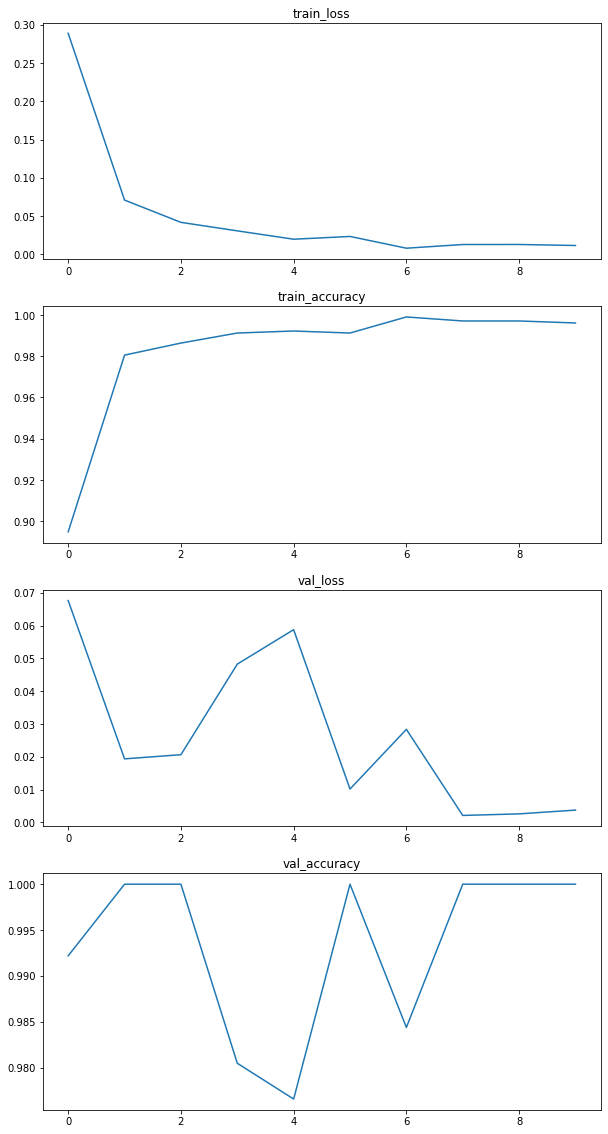

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,20))

plt.subplot(4,1,1)
plt.plot(history.history['loss'])
plt.title('train_loss');

plt.subplot(4,1,2)
plt.plot(history.history['accuracy'])
plt.title('train_accuracy');

plt.subplot(4,1,3)
plt.plot(history.history['val_loss'])
plt.title('val_loss');

plt.subplot(4,1,4)
plt.plot(history.history['val_accuracy'])
plt.title('val_accuracy');

In [18]:
model.load_weights('checkpoints/horses-or-humans/HOHCP')
loss, acc = model.evaluate(train_generator, verbose=2)
print("model, accuracy: {:5.2f}%".format(100*acc))


33/33 - 47s - loss: 0.0708 - accuracy: 0.9737
model, accuracy: 97.37%
